In [1]:
%matplotlib inline

In [2]:
#
# We need a regression model for predicting PDR (highest priority): 
# Variables are: 
#   - Number of unique CpGs per cell
#   - Median Average Read CpG per cell (or mean if normally distributed)
#   - BS rate per cell
#   - CLL or Normal status per cell
# What is the coefficient and the P value for each variable for a model predicting PDR?

In [3]:
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
pd.set_option('display.max_columns', 50) # print all rows


import os
os.chdir('/Users/evanbiederstedt/Downloads/RRBS_data_files')

In [4]:
normal_cellA_df = pd.read_csv("Meth_PDR_cell_RRBS_normal_B1_ALL.csv")
normal_cellB_df = pd.read_csv("Meth_PDR_cell_normalpcell_ALL.csv")
normal_cellC_df = pd.read_csv("Meth_PDR_cell_normalmcell_ALL.csv")
cll_cellA_df = pd.read_csv("Meth_PDR_cell_CLL_RRBS_cw154_ALL.csv")
cll_cellC_df = pd.read_csv("Meth_PDR_cell_CLL_RRBS_trito_pool_C_ALL.csv")

In [5]:
normal_cellA_df = normal_cellA_df.drop(["Unnamed: 0"], axis=1)  
normal_cellA_df["type"] = str('normal')
normal_cellA_df["bio"] = str('normal_B')
normal_cellA_df["protocol"] = normal_cellA_df["filename"].str[5:24]
normal_cellA_df["filename"] = normal_cellA_df["filename"].str[:40]

In [6]:
cpg1 = pd.read_csv('Meth_PDR_cell_RRBS_normal_B1_CpGs.csv')
cpg1 = cpg1.drop(["Unnamed: 0"], axis=1)  
cpg1["filename"] = cpg1["filename"].str[:40]
normal_cellA_df = pd.merge(normal_cellA_df, cpg1, how='inner')
normal_cellB_df["type"] = str('normal')
normal_cellB_df = normal_cellB_df.drop(["Unnamed: 0"], axis=1) 
normal_cellB_df["bio"] = str('CD27p')
normal_cellB_df["protocol"] = normal_cellB_df["filename"].str[5:31]
normal_cellB_df["filename"] = normal_cellB_df["filename"].str[:50]
normal_cellB_df["filename"] = normal_cellB_df["filename"].str.replace(r'.dan$', '')
normal_cellB_df["filename"] = normal_cellB_df["filename"].str.replace(r'.da$', '')
cpg2 = pd.read_csv('NormalBCD19pCD27pcell_CpGs.csv')
cpg2 = cpg2.drop(["Unnamed: 0"], axis=1)  
cpg2["filename"] = cpg2["filename"].str[:50]
cpg2["filename"] = cpg2["filename"].str.replace(r'.dan$', '')
cpg2["filename"] = cpg2["filename"].str.replace(r'.da$', '')
normal_cellB_df = pd.merge(normal_cellB_df, cpg2, how='inner')
normal_cellC_df = normal_cellC_df.drop(["Unnamed: 0"], axis=1)  
normal_cellC_df["type"] = str('normal')
normal_cellC_df["protocol"] = normal_cellC_df["filename"].str[5:31]
normal_cellC_df["bio"] = str('CD27m')
normal_cellC_df["filename"] = normal_cellC_df["filename"].str[:50]
normal_cellC_df["filename"] = normal_cellC_df["filename"].str.replace(r'.dan$', '')
normal_cellC_df["filename"] = normal_cellC_df["filename"].str.replace(r'.da$', '')
cpg3 = pd.read_csv("NormalBCD19pCD27mcell_CpGs.csv")
cpg3 = cpg3.drop(["Unnamed: 0"], axis=1)  
cpg3["filename"] = cpg3["filename"].str[:50]
cpg3["filename"] = cpg3["filename"].str.replace(r'.dan$', '')
cpg3["filename"] = cpg3["filename"].str.replace(r'.da$', '')
normal_cellC_df = pd.merge(normal_cellC_df, cpg3, how='inner')
frames3 = [normal_cellA_df, normal_cellB_df, normal_cellC_df]
normal_result = pd.concat(frames3)
print(normal_result.shape)
print(normal_result.columns)

(304, 11)
Index(['PDR_total', 'avgReadCpGs_mean', 'avgReadCpGs_median', 'bio',
       'filename', 'methylation', 'mixedReadCount', 'protocol', 'thisMeth',
       'total_reads', 'type'],
      dtype='object')


In [7]:
normal_result = normal_result[['filename', 'PDR_total', 'total_reads', 'type', 'bio', 'protocol', 'avgReadCpGs_mean', 'avgReadCpGs_median']]

In [8]:
cll_cellA_df = cll_cellA_df.drop(["Unnamed: 0"], axis=1) 
cll_cellA_df["type"] = str('CLL')
cll_cellA_df["protocol"] = cll_cellA_df["filename"].str[5:34]
cll_cellA_df["protocol"][cll_cellA_df["protocol"] == 'cw154_CutSmart_proteinase_K_T'] = 'cw154_CutSmart_proteinase_K'
cll_cellA_df["protocol"][cll_cellA_df["protocol"] == 'cw154_Tris_protease_GR_CAGAGA'] = 'cw154_Tris_protease_GR'
cll_cellA_df["protocol"][(cll_cellA_df["protocol"] != 
        'cw154_Tris_protease_GR') & (cll_cellA_df["protocol"] != 'cw154_CutSmart_proteinase_K')] = 'cw154_Tris_protease'
cll_cellA_df["bio"] = str('CLL')
cll_cellA_df["filename"] = cll_cellA_df["filename"].str[:51]
cll_cellA_df["filename"] = cll_cellA_df["filename"].str.replace(r'.da$', '')
cll_cellA_df["filename"] = cll_cellA_df["filename"].str.replace(r'.annoRR$', '')
cll_cellA_df["filename"] = cll_cellA_df["filename"].str.replace(r'.ann$', '')
cll_cellA_df["filename"] = cll_cellA_df["filename"].str.replace(r'.dan$', '')
cpg4 = pd.read_csv('CLL_RRBS_cw154_A_CpGs.csv')
cpg4 = cpg4.drop(["Unnamed: 0"], axis=1)  
cpg4["filename"] = cpg4["filename"].str[:51]
cpg4["filename"] = cpg4["filename"].str.replace(r'.da$', '')
cpg4["filename"] = cpg4["filename"].str.replace(r'.annoRR$', '')
cpg4["filename"] = cpg4["filename"].str.replace(r'.ann$', '')
cpg4["filename"] = cpg4["filename"].str.replace(r'.dan$', '')
cll_cellA_df = pd.merge(cll_cellA_df, cpg4, how='inner')
cll_cellC_df = cll_cellC_df.drop(["Unnamed: 0"], axis=1) 
cll_cellC_df["type"] = str('CLL')
cll_cellC_df["bio"] = str('CLL')
cll_cellC_df["protocol"] = cll_cellC_df["filename"].str[5:17]
cll_cellC_df["filename"] = cll_cellC_df["filename"].str[:33]
cpg5 = pd.read_csv('Meth_PDR_cell_RRBS_trito_pool_CpGs.csv')
cpg5 = cpg5.drop(["Unnamed: 0"], axis=1) 
cpg5["filename"] = cpg5["filename"].str[:33]
cll_cellC_df = pd.merge(cll_cellC_df, cpg5, how='inner')
frames2 = [cll_cellA_df, cll_cellC_df]
cll_result = pd.concat(frames2)
print(cll_result.shape)
print(cll_result.columns)

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(110, 11)
Index(['PDR_total', 'avgReadCpGs_mean', 'avgReadCpGs_median', 'bio',
       'filename', 'methylation', 'mixedReadCount', 'protocol', 'thisMeth',
       'total_reads', 'type'],
      dtype='object')


In [9]:
cll_result = cll_result[['filename', 'PDR_total', 'total_reads', 'type', 'bio', 'protocol', 'avgReadCpGs_mean', 'avgReadCpGs_median']]
cll_result = cll_result.reset_index(drop=True)
normal_result = normal_result.reset_index(drop=True)
combined2 = normal_result.append(cll_result)
combined2 = combined2.reset_index(drop=True)
combined2.head()

,filename,PDR_total,total_reads,type,bio,protocol,avgReadCpGs_mean,avgReadCpGs_median
0,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACAACC,0.259001,11894660.0,normal,normal_B,normal_B_cell_A1_24,5.295301,4.0
1,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACCGCG,0.411448,3744659.0,normal,normal_B,normal_B_cell_A1_24,5.285714,4.0
2,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACGTGG,0.278568,10461874.0,normal,normal_B,normal_B_cell_A1_24,5.453122,5.0
3,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACTCAC,0.384385,14051.0,normal,normal_B,normal_B_cell_A1_24,4.950166,4.0
4,RRBS_normal_B_cell_A1_24_TAAGGCGA.AGGATG,0.248006,21928743.0,normal,normal_B,normal_B_cell_A1_24,5.366276,5.0


In [10]:
bs = pd.read_table('allStats.txt')
bs = bs.drop('sample.1', axis=1)
bs = bs.drop('sample.2', axis=1)
bs = bs.reset_index(drop=True)
bs = bs.drop('class', axis=1)
bs = bs.drop('totMeth', axis=1)
bs = bs.drop('totSeen', axis=1)
bs = bs.drop('avSum', axis=1)
bs = bs.drop('avTot', axis=1)
bs = bs.drop('rMixed', axis=1)
bs = bs.drop('rTot', axis=1)
bs = bs.drop('rAv', axis=1)
bs = bs.drop('rAvTot', axis=1)
bs = bs.drop('bed', axis=1)
bs = bs.drop('methInfoFile', axis=1)
bs = bs.drop('totReads', axis=1)
bs = bs.drop('totAligned', axis=1)
bs = bs.drop('totClipped', axis=1)
bs = bs.drop('totSeenCpG', axis=1)
bs = bs.drop('totUsed', axis=1)
bs = bs.drop('totMethCpG', axis=1)
# bs = bs.drop('totCpG', axis=1)
bs = bs.drop('totalReadPairs', axis=1)
bs = bs.drop('alignedReads', axis=1)
bs = bs.drop('totalReads', axis=1)
bs = bs.rename(columns = {'sample':'filename'})

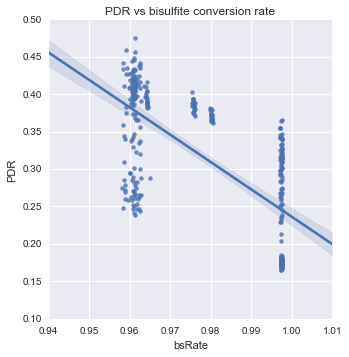

In [11]:
merged = pd.merge(combined2, bs, how='inner')
merged = merged.reset_index(drop=True)
merged = merged.rename(columns = {'PDR_total':'PDR'})
merged = merged.rename(columns = {'totCpG':'Unique_CpGs'})
# Remove all data points with less than 100k in totcpg 
merged = merged[merged['total_reads'] > 100000]
scattermatrix1 = merged.drop(['filename', 'total_reads', 'type', 'protocol', 'avgReadCpGs_median'], axis=1)
sns.lmplot(x="bsRate", y="PDR",  data=scattermatrix1)
plt.title("PDR vs bisulfite conversion rate")

In [12]:
scattermatrix7 = merged.drop(['filename', 'bio', 'avgReadCpGs_median'], axis=1)
y = scattermatrix7.PDR # dependent variable
print(y.shape)
X = scattermatrix7.drop(['PDR', 'total_reads', 'protocol'], axis=1)
print(X.shape)

categorical_variables = ['type']
for variable in categorical_variables:
    # Fill missing data with the word "Missing"
    X[variable].fillna("Missing", inplace=True)
    # Create array of dummies
    dummies = pd.get_dummies(X[variable], prefix=variable)
    # Update X to include dummies and drop the main variable
    X = pd.concat([X, dummies], axis=1)
    X.drop([variable], axis=1, inplace=True)
    
import statsmodels.api as sm
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for CLL 'RRBS_trito_pool1', predictPDR")
print("Variables: Number of unique CpGs per cell, mean Average Read CpG per cell, BS rate, Cll or Normal B")
est.summary()

(358,)
(358, 4)
Regression results for CLL 'RRBS_trito_pool1', predictPDR
Variables: Number of unique CpGs per cell, mean Average Read CpG per cell, BS rate, Cll or Normal B


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PDR   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     130.8
Date:                Fri, 08 Jul 2016   Prob (F-statistic):           2.21e-68
Time:                        20:44:39   Log-Likelihood:                 517.70
No. Observations:                 358   AIC:                            -1025.
Df Residuals:                     353   BIC:                            -1006.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const                2.5550      0.153     16.680      0.000         2.254     2.856
avgReadCpGs_mean    -0.1049      0.023     -4.529      0.000        -0.150    -0.059
Unique_CpGs       1.254e-08   1.27e-08      0.988      0.324     -1.24e-08  3.75e-08
bsRate              -3.0091      0.194    -15.506      0.000        -3.391    -2.627
type_CLL             1.3107      0.076     17.278      0.000         1.162     1.460
type_normal          1.2443      0.077     16.057      0.000         1.092     1.397
==============================================================================
Omnibus:                       50.222   Durbin-Watson:                   1.124
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.701
Skew:                           0.111   Prob(JB):                      0.00106
Kurtosis:                       2.068   Cond. No.                     6.18e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.03e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [13]:
tritopool = merged[merged["protocol"] == 'trito_pool_1']
tritopool = tritopool.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
tritopoolA = tritopool.set_index("filename")
from itertools import combinations
cc = list(combinations(tritopool.filename,2))
out = pd.DataFrame([tritopoolA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(tritopool.PDR, tritopool.PDR)), tritopool.filename, tritopool.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs = pd.merge(out, pdr_differences, how='inner')
print(pairs.shape)
pairs = pairs.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs.PDR_difference # dependent variable
X = pairs.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
print(y.shape)
print(X.shape)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for CLL 'RRBS_trito_pool1', predict \delta PDR")
est.summary()

(210, 7)
(210,)
(210, 3)
Regression results for CLL 'RRBS_trito_pool1', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     3.185
Date:                Fri, 08 Jul 2016   Prob (F-statistic):             0.0248
Time:                        20:44:39   Log-Likelihood:                 829.70
No. Observations:                 210   AIC:                            -1651.
Df Residuals:                     206   BIC:                            -1638.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const                3.6496      4.508      0.810      0.419        -5.239    12.538
avgReadCpGs_mean    -0.0163      0.006     -2.663      0.008        -0.028    -0.004
Unique_CpGs_mean -1.437e-09   4.25e-09     -0.338      0.736     -9.82e-09  6.94e-09
bsRate_mean         -3.6250      4.595     -0.789      0.431       -12.683     5.434
==============================================================================
Omnibus:                       10.985   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.478
Skew:                           0.545   Prob(JB):                      0.00322
Kurtosis:                       2.649   Cond. No.                     1.72e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.72e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


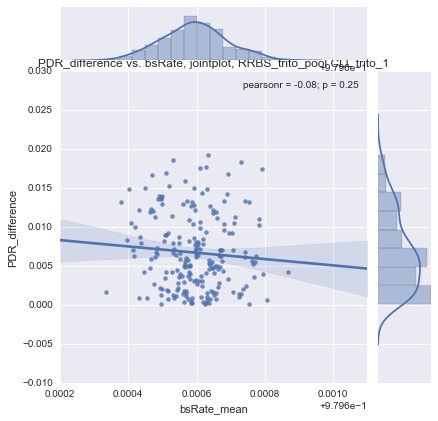

In [14]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, RRBS_trito_pool CLL trito_1")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


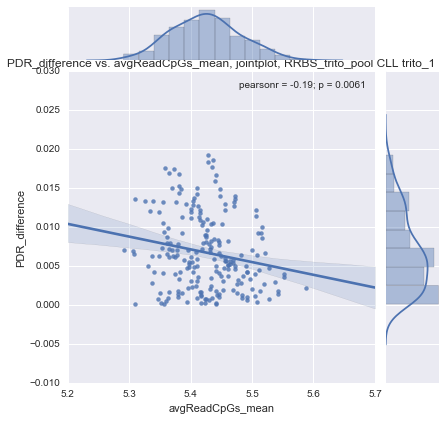

In [15]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, RRBS_trito_pool CLL trito_1")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


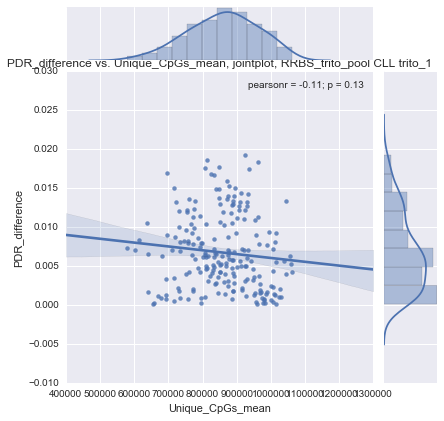

In [16]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, RRBS_trito_pool CLL trito_1")

In [17]:
tritopool2 = merged[merged["protocol"] == 'trito_pool_2']
tritopool2 = tritopool2.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
tritopool2A = tritopool2.set_index("filename")
from itertools import combinations
cc = list(combinations(tritopool2.filename,2))
out = pd.DataFrame([tritopool2A.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(tritopool2.PDR, tritopool2.PDR)), tritopool2.filename, tritopool2.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs1a = pd.merge(out, pdr_differences, how='inner')
print(pairs1a.shape)
pairs1a = pairs1a.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs1a.PDR_difference # dependent variable
X = pairs1a.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
print(y.shape)
print(X.shape)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for CLL 'RRBS_trito_pool_2', predict \delta PDR")
est.summary()

(253, 7)
(253,)
(253, 3)
Regression results for CLL 'RRBS_trito_pool_2', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     7.687
Date:                Fri, 08 Jul 2016   Prob (F-statistic):           6.22e-05
Time:                        20:44:44   Log-Likelihood:                 930.58
No. Observations:                 253   AIC:                            -1853.
Df Residuals:                     249   BIC:                            -1839.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               13.5180      3.779      3.578      0.000         6.076    20.960
avgReadCpGs_mean     0.0309      0.008      4.075      0.000         0.016     0.046
Unique_CpGs_mean  3.098e-09   3.14e-09      0.987      0.325     -3.08e-09  9.28e-09
bsRate_mean        -14.0200      3.891     -3.604      0.000       -21.683    -6.357
==============================================================================
Omnibus:                       15.206   Durbin-Watson:                   2.196
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.280
Skew:                           0.610   Prob(JB):                     0.000292
Kurtosis:                       3.236   Cond. No.                     1.24e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


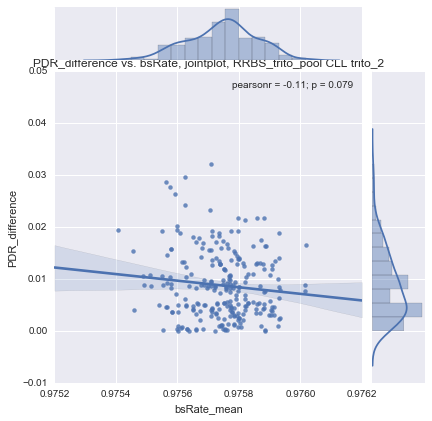

In [18]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs1a, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, RRBS_trito_pool CLL trito_2")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


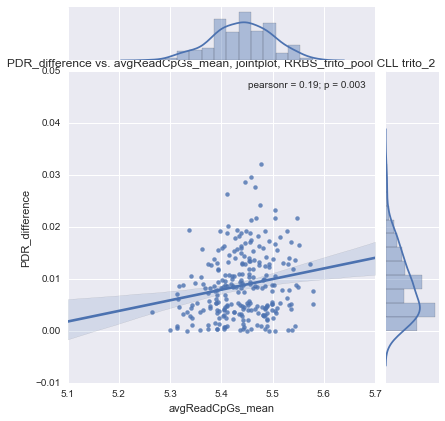

In [19]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs1a, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, RRBS_trito_pool CLL trito_2")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


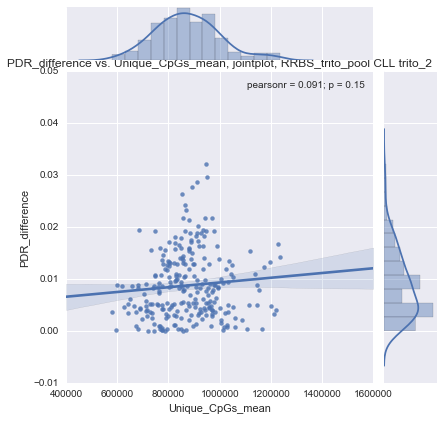

In [20]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs1a, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, RRBS_trito_pool CLL trito_2")

In [21]:
cw154 = merged[merged["protocol"] == 'cw154_Tris_protease']
cw154 = cw154.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
cw154 = cw154.reset_index(drop=True)
cw154A = cw154.set_index("filename")
from itertools import combinations
cc = list(combinations(cw154.filename,2))
out = pd.DataFrame([cw154A.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(cw154.PDR, cw154.PDR)), cw154.filename, cw154.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs2 = pd.merge(out, pdr_differences, how='inner')
pairs2 = pairs2.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs2.PDR_difference # dependent variable
X = pairs2.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for CLL 'cw154_Tris_protease', predict \delta PDR")
est.summary()

Regression results for CLL 'cw154_Tris_protease', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     4.275
Date:                Fri, 08 Jul 2016   Prob (F-statistic):            0.00593
Time:                        20:44:50   Log-Likelihood:                 785.16
No. Observations:                 210   AIC:                            -1562.
Df Residuals:                     206   BIC:                            -1549.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const                3.9919      2.605      1.532      0.127        -1.145     9.129
avgReadCpGs_mean     0.0002      0.005      0.036      0.971        -0.010     0.011
Unique_CpGs_mean -9.202e-09   3.72e-09     -2.475      0.014     -1.65e-08 -1.87e-09
bsRate_mean         -4.1420      2.727     -1.519      0.130        -9.518     1.234
==============================================================================
Omnibus:                       13.855   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                8.516
Skew:                           0.341   Prob(JB):                       0.0142
Kurtosis:                       2.288   Cond. No.                     3.92e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.92e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


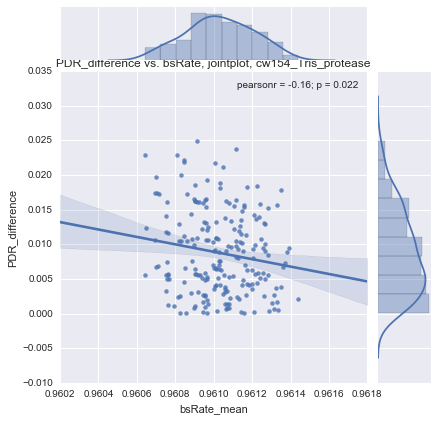

In [22]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs2, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, cw154_Tris_protease")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


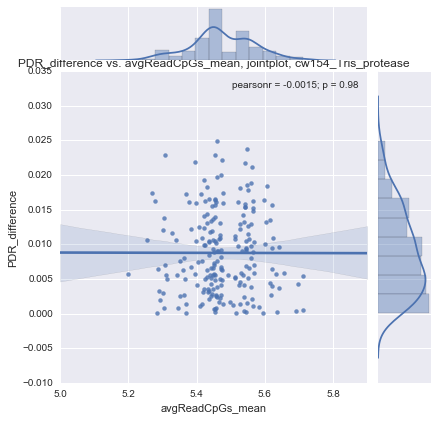

In [23]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs2, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, cw154_Tris_protease")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


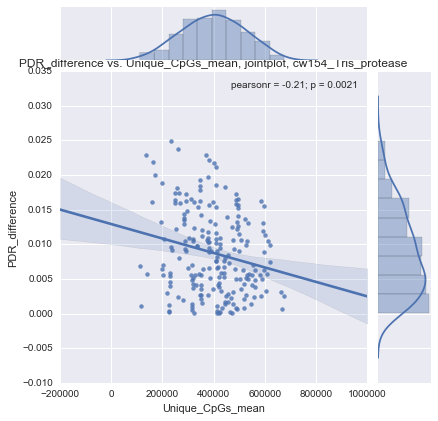

In [24]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs2, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, cw154_Tris_protease")

In [25]:
cw154 = merged[merged["protocol"] == 'cw154_Tris_protease_GR']
cw154 = cw154.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
cw154 = cw154.reset_index(drop=True)
cw154A = cw154.set_index("filename")
from itertools import combinations
cc = list(combinations(cw154.filename,2))
out = pd.DataFrame([cw154A.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(cw154.PDR, cw154.PDR)), cw154.filename, cw154.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs2a = pd.merge(out, pdr_differences, how='inner')
pairs2a = pairs2a.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs2a.PDR_difference # dependent variable
X = pairs2a.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for CLL 'RRBS_cw154_Tris_protease_GR', predict \delta PDR")
est.summary()

Regression results for CLL 'RRBS_cw154_Tris_protease_GR', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     4.018
Date:                Fri, 08 Jul 2016   Prob (F-statistic):            0.00832
Time:                        20:44:55   Log-Likelihood:                 731.42
No. Observations:                 210   AIC:                            -1455.
Df Residuals:                     206   BIC:                            -1441.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               -7.3369      3.463     -2.119      0.035       -14.164    -0.510
avgReadCpGs_mean    -0.0050      0.006     -0.897      0.371        -0.016     0.006
Unique_CpGs_mean -9.495e-09   3.94e-09     -2.407      0.017     -1.73e-08 -1.72e-09
bsRate_mean          7.6789      3.620      2.121      0.035         0.541    14.817
==============================================================================
Omnibus:                       20.796   Durbin-Watson:                   1.309
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.844
Skew:                           0.795   Prob(JB):                     6.64e-06
Kurtosis:                       3.444   Cond. No.                     5.05e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.05e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


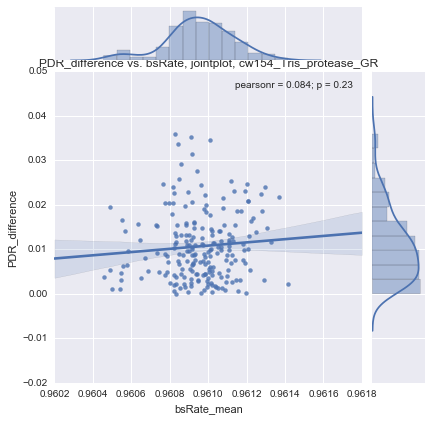

In [26]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs2a, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, cw154_Tris_protease_GR")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


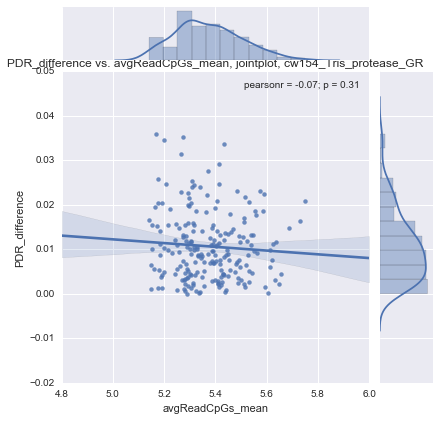

In [27]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs2a, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, cw154_Tris_protease_GR")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


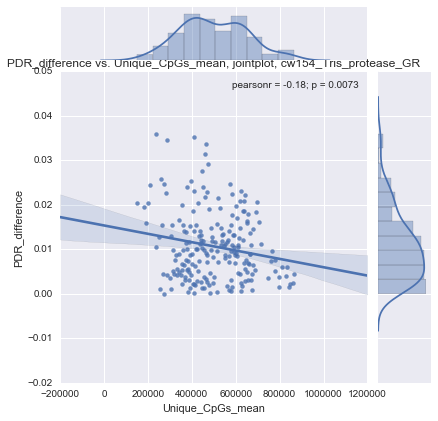

In [28]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs2a, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, cw154_Tris_protease_GR")

In [29]:
# cw154_CutSmart_proteinase_K
cw154 = merged[merged["protocol"] == 'cw154_CutSmart_proteinase_K']
cw154 = cw154.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
cw154 = cw154.reset_index(drop=True)
cw154A = cw154.set_index("filename")
from itertools import combinations
cc = list(combinations(cw154.filename,2))
out = pd.DataFrame([cw154A.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(cw154.PDR, cw154.PDR)), cw154.filename, cw154.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs2b = pd.merge(out, pdr_differences, how='inner')
pairs2b = pairs2b.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs2b.PDR_difference # dependent variable
X = pairs2b.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for CLL 'cw154_CutSmart_proteinase_K', predict \delta PDR")
est.summary()

Regression results for CLL 'cw154_CutSmart_proteinase_K', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     221.9
Date:                Fri, 08 Jul 2016   Prob (F-statistic):           3.02e-64
Time:                        20:45:00   Log-Likelihood:                 596.51
No. Observations:                 210   AIC:                            -1185.
Df Residuals:                     206   BIC:                            -1172.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -87.4036      5.257    -16.626      0.000       -97.768   -77.039
avgReadCpGs_mean    -0.0709      0.022     -3.206      0.002        -0.114    -0.027
Unique_CpGs_mean -9.788e-08   8.35e-09    -11.718      0.000     -1.14e-07 -8.14e-08
bsRate_mean         91.1247      5.452     16.714      0.000        80.376   101.873
==============================================================================
Omnibus:                        2.566   Durbin-Watson:                   1.517
Prob(Omnibus):                  0.277   Jarque-Bera (JB):                2.339
Skew:                          -0.257   Prob(JB):                        0.310
Kurtosis:                       3.061   Cond. No.                     5.01e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.01e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


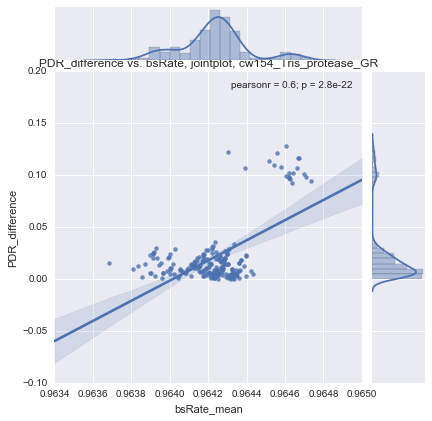

In [30]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs2b, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, cw154_Tris_protease_GR")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


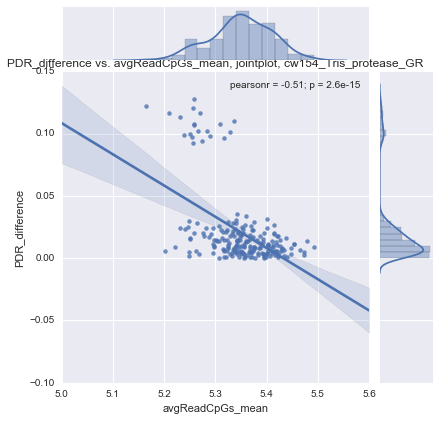

In [31]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs2b, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, cw154_Tris_protease_GR")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


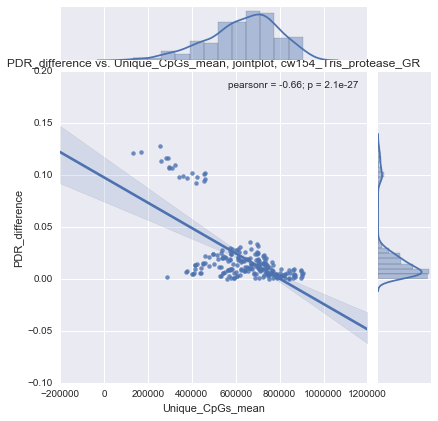

In [32]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs2b, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, cw154_Tris_protease_GR")

In [33]:
pcell = merged[merged["protocol"] == 'NormalBCD19pCD27pcell1_22_']
pcell = pcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
pcell = pcell.reset_index(drop=True)
pcellA = pcell.set_index("filename")
from itertools import combinations
cc = list(combinations(pcell.filename,2))
out = pd.DataFrame([pcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(pcell.PDR, pcell.PDR)), pcell.filename, pcell.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs3 = pd.merge(out, pdr_differences, how='inner')
pairs3 = pairs3.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs3.PDR_difference # dependent variable
X = pairs3.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for Normal B 'NormalBCD19pCD27pcell1_22', predict \delta PDR")
est.summary()

Regression results for Normal B 'NormalBCD19pCD27pcell1_22', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.4630
Date:                Fri, 08 Jul 2016   Prob (F-statistic):              0.709
Time:                        20:45:05   Log-Likelihood:                 278.32
No. Observations:                 153   AIC:                            -548.6
Df Residuals:                     149   BIC:                            -536.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -17.9097     56.071     -0.319      0.750      -128.706    92.887
avgReadCpGs_mean    -0.0496      0.053     -0.933      0.352        -0.154     0.055
Unique_CpGs_mean  6.966e-09    4.2e-08      0.166      0.869      -7.6e-08     9e-08
bsRate_mean         18.2753     56.205      0.325      0.746       -92.787   129.337
==============================================================================
Omnibus:                       13.253   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.901
Skew:                           0.764   Prob(JB):                     0.000581
Kurtosis:                       2.940   Cond. No.                     9.28e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.28e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


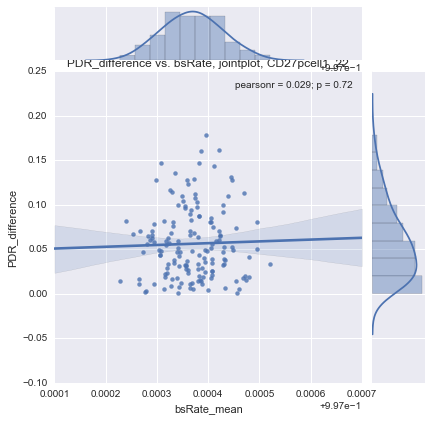

In [34]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs3, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, CD27pcell1_22")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


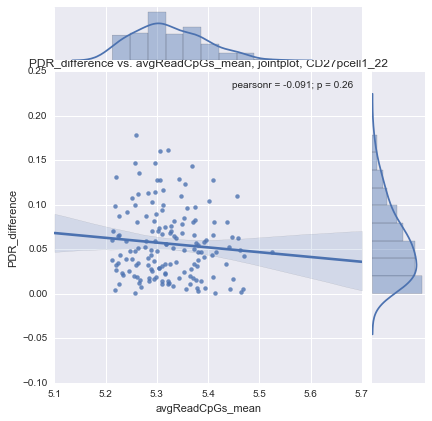

In [35]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs3, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, CD27pcell1_22")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


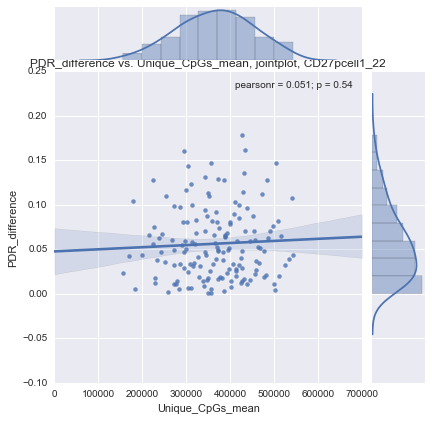

In [36]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs3, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, CD27pcell1_22")

In [37]:
pcell = merged[merged["protocol"] == 'NormalBCD19pCD27pcell23_44']
pcell = pcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
pcell = pcell.reset_index(drop=True)
pcellA = pcell.set_index("filename")
from itertools import combinations
cc = list(combinations(pcell.filename,2))
out = pd.DataFrame([pcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(pcell.PDR, pcell.PDR)), pcell.filename, pcell.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs3a = pd.merge(out, pdr_differences, how='inner')
pairs3a = pairs3a.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs3a.PDR_difference # dependent variable
X = pairs3a.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for Normal B 'NormalBCD19pCD27pcell22_34', predict \delta PDR")
est.summary()

Regression results for Normal B 'NormalBCD19pCD27pcell22_34', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2.494
Date:                Fri, 08 Jul 2016   Prob (F-statistic):             0.0608
Time:                        20:45:10   Log-Likelihood:                 514.09
No. Observations:                 231   AIC:                            -1020.
Df Residuals:                     227   BIC:                            -1006.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -50.6035     43.753     -1.157      0.249      -136.817    35.610
avgReadCpGs_mean     0.0562      0.022      2.515      0.013         0.012     0.100
Unique_CpGs_mean      3e-08   2.66e-08      1.129      0.260     -2.24e-08  8.24e-08
bsRate_mean         50.4462     43.835      1.151      0.251       -35.928   136.821
==============================================================================
Omnibus:                       35.416   Durbin-Watson:                   1.393
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.591
Skew:                           1.059   Prob(JB):                     7.64e-11
Kurtosis:                       3.599   Cond. No.                     1.28e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


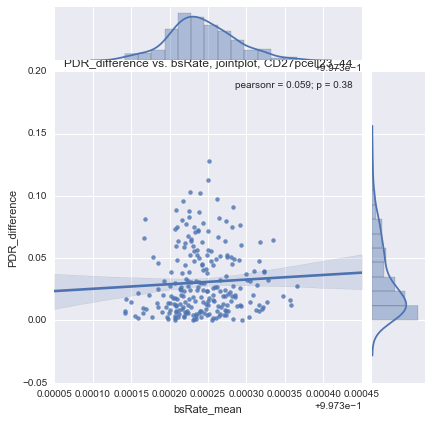

In [38]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs3a, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, CD27pcell23_44")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


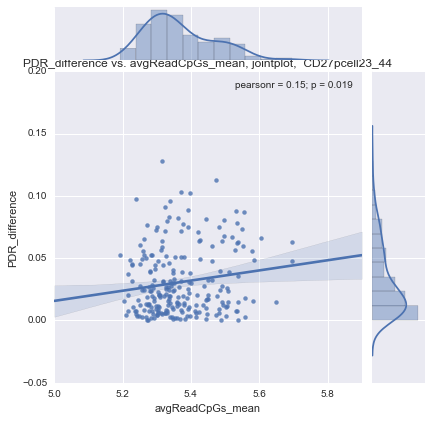

In [39]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs3a, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot,  CD27pcell23_44")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


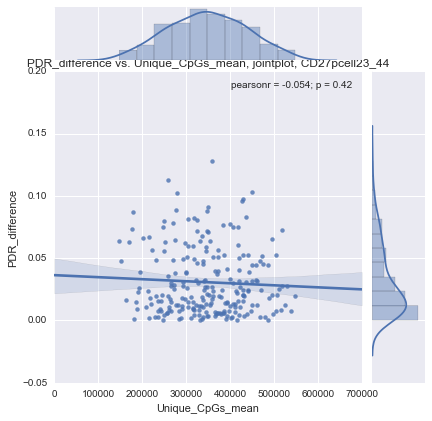

In [40]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs3a, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, CD27pcell23_44")

In [41]:
pcell = merged[merged["protocol"] == 'NormalBCD19pCD27pcell45_66']
pcell = pcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
pcell = pcell.reset_index(drop=True)
pcellA = pcell.set_index("filename")
from itertools import combinations
cc = list(combinations(pcell.filename,2))
out = pd.DataFrame([pcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(pcell.PDR, pcell.PDR)), pcell.filename, pcell.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs3b = pd.merge(out, pdr_differences, how='inner')
pairs3b = pairs3b.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs3b.PDR_difference # dependent variable
X = pairs3b.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for Normal B 'NormalBCD19pCD27pcell45_66', predict \delta PDR")
est.summary()

Regression results for Normal B 'NormalBCD19pCD27pcell45_66', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     2.407
Date:                Fri, 08 Jul 2016   Prob (F-statistic):             0.0854
Time:                        20:45:14   Log-Likelihood:                 77.705
No. Observations:                  36   AIC:                            -147.4
Df Residuals:                      32   BIC:                            -141.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const             -170.3190    211.440     -0.806      0.426      -601.008   260.370
avgReadCpGs_mean     0.1278      0.072      1.766      0.087        -0.020     0.275
Unique_CpGs_mean -1.225e-08   2.99e-08     -0.409      0.685     -7.32e-08  4.87e-08
bsRate_mean        170.0991    211.669      0.804      0.428      -261.057   601.256
==============================================================================
Omnibus:                        1.527   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.466   Jarque-Bera (JB):                1.462
Skew:                           0.418   Prob(JB):                        0.481
Kurtosis:                       2.474   Cond. No.                     3.46e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.46e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


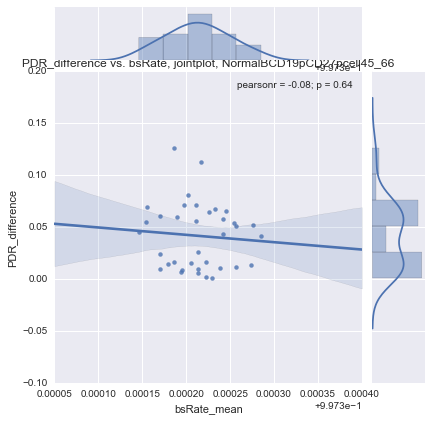

In [42]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs3b, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, NormalBCD19pCD27pcell45_66")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


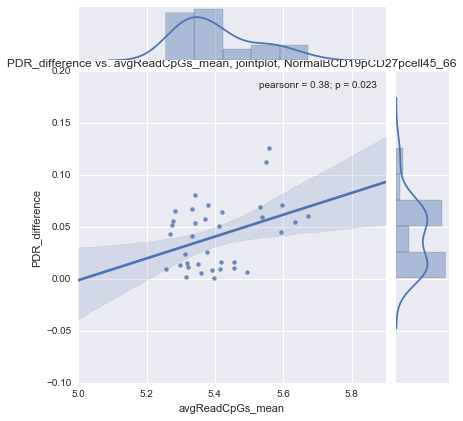

In [43]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs3b, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, NormalBCD19pCD27pcell45_66")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


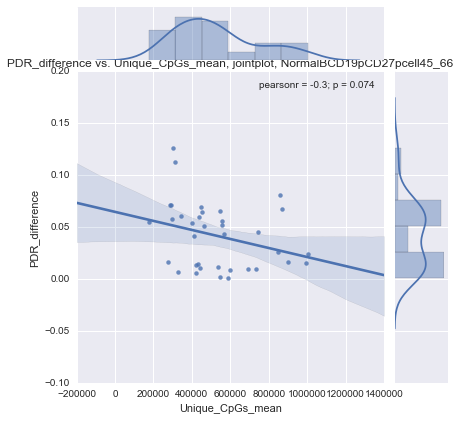

In [44]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs3b, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, NormalBCD19pCD27pcell45_66")

In [45]:
pcell = merged[merged["protocol"] == 'NormalBCD19pCD27pcell67_88']
pcell = pcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
pcell = pcell.reset_index(drop=True)
pcellA = pcell.set_index("filename")
from itertools import combinations
cc = list(combinations(pcell.filename,2))
out = pd.DataFrame([pcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(pcell.PDR, pcell.PDR)), pcell.filename, pcell.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs3c = pd.merge(out, pdr_differences, how='inner')
pairs3c = pairs3c.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs3c.PDR_difference # dependent variable
X = pairs3c.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for Normal B 'NormalBCD19pCD27pcell67_88', predict \delta PDR")
est.summary()

Regression results for Normal B 'NormalBCD19pCD27pcell67_88', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2.322
Date:                Fri, 08 Jul 2016   Prob (F-statistic):             0.0762
Time:                        20:45:18   Log-Likelihood:                 445.61
No. Observations:                 210   AIC:                            -883.2
Df Residuals:                     206   BIC:                            -869.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               24.1250     43.671      0.552      0.581       -61.975   110.225
avgReadCpGs_mean    -0.0896      0.046     -1.950      0.053        -0.180     0.001
Unique_CpGs_mean  3.472e-08   2.56e-08      1.354      0.177     -1.58e-08  8.53e-08
bsRate_mean        -23.6911     43.699     -0.542      0.588      -109.845    62.463
==============================================================================
Omnibus:                       11.910   Durbin-Watson:                   1.585
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.949
Skew:                           0.606   Prob(JB):                      0.00154
Kurtosis:                       2.891   Cond. No.                     1.06e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


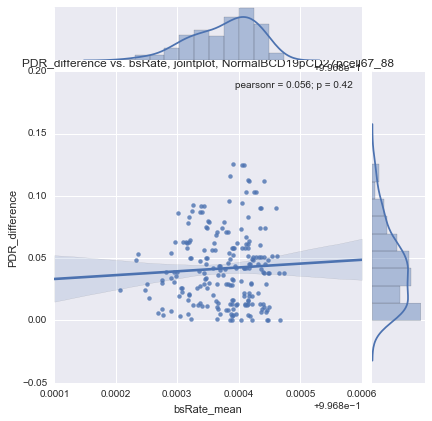

In [46]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs3c, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, NormalBCD19pCD27pcell67_88")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


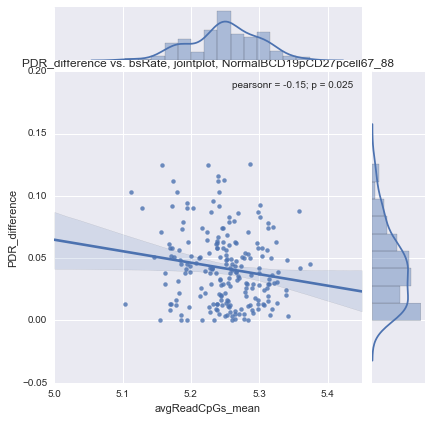

In [47]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs3c, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, NormalBCD19pCD27pcell67_88")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


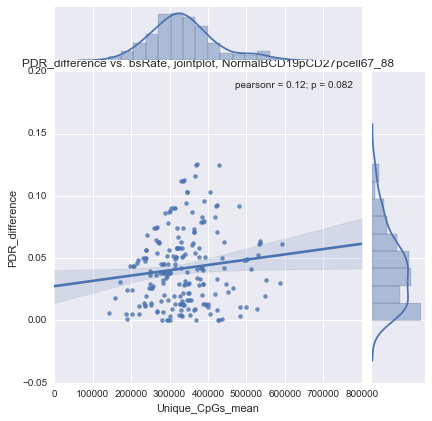

In [48]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs3c, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, NormalBCD19pCD27pcell67_88")

In [49]:
mcell = merged[merged["protocol"] == 'NormalBCD19pCD27mcell1_22_']
mcell = mcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
mcell = mcell.reset_index(drop=True)
mcellA = mcell.set_index("filename")
from itertools import combinations
cc = list(combinations(mcell.filename,2))
out = pd.DataFrame([mcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(mcell.PDR, mcell.PDR)), mcell.filename, mcell.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs4 = pd.merge(out, pdr_differences, how='inner')
pairs4 = pairs4.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs4.PDR_difference # dependent variable
X = pairs4.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'NormalBCD19pCD27mcell1_22', predict \delta PDR")
est.summary()

Regression results for 'NormalBCD19pCD27mcell1_22', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     17.67
Date:                Fri, 08 Jul 2016   Prob (F-statistic):           7.25e-10
Time:                        20:45:22   Log-Likelihood:                 436.78
No. Observations:                 153   AIC:                            -865.6
Df Residuals:                     149   BIC:                            -853.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              212.8068     33.562      6.341      0.000       146.487   279.126
avgReadCpGs_mean     0.0619      0.020      3.047      0.003         0.022     0.102
Unique_CpGs_mean -3.658e-08    1.9e-08     -1.928      0.056     -7.41e-08  9.05e-10
bsRate_mean       -213.6940     33.688     -6.343      0.000      -280.263  -147.126
==============================================================================
Omnibus:                       50.832   Durbin-Watson:                   1.651
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.271
Skew:                           1.581   Prob(JB):                     2.05e-21
Kurtosis:                       5.223   Cond. No.                     1.65e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.65e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


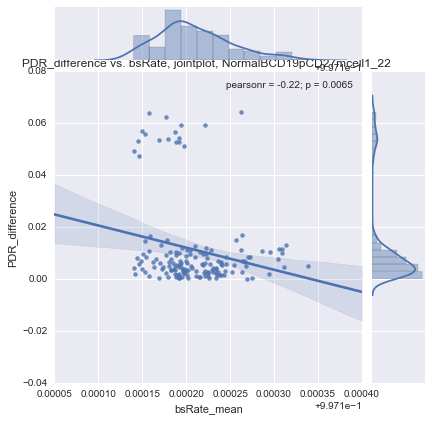

In [50]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs4, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, NormalBCD19pCD27mcell1_22 ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


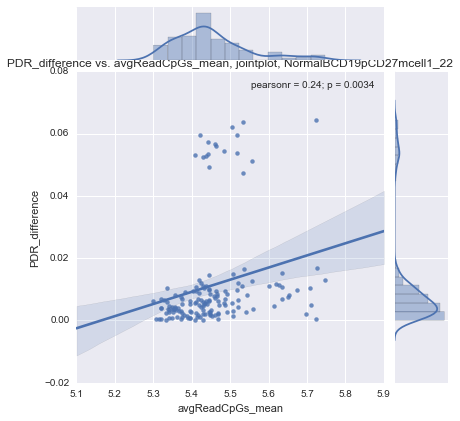

In [51]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs4, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, NormalBCD19pCD27mcell1_22")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


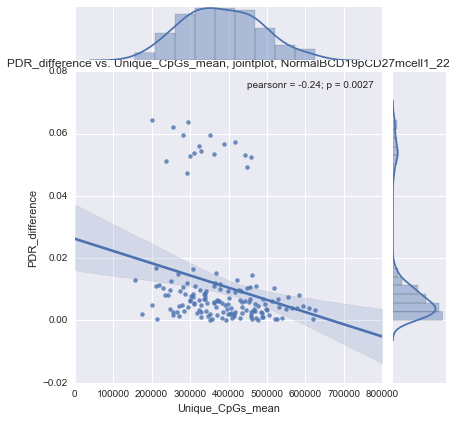

In [52]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs4, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, NormalBCD19pCD27mcell1_22")

In [53]:
mcell = merged[merged["protocol"] == 'NormalBCD19pCD27mcell23_44']
mcell = mcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
mcell = mcell.reset_index(drop=True)
mcellA = mcell.set_index("filename")
from itertools import combinations
cc = list(combinations(mcell.filename,2))
out = pd.DataFrame([mcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(mcell.PDR, mcell.PDR)), mcell.filename, mcell.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs4a = pd.merge(out, pdr_differences, how='inner')
pairs4a = pairs4a.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs4a.PDR_difference # dependent variable
X = pairs4a.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'NormalBCD19pCD27mcell23_44', predict \delta PDR")
est.summary()

Regression results for 'NormalBCD19pCD27mcell23_44', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     7.489
Date:                Fri, 08 Jul 2016   Prob (F-statistic):           9.85e-05
Time:                        20:45:27   Log-Likelihood:                 433.73
No. Observations:                 171   AIC:                            -859.5
Df Residuals:                     167   BIC:                            -846.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -16.6532     56.889     -0.293      0.770      -128.968    95.662
avgReadCpGs_mean    -0.0507      0.041     -1.245      0.215        -0.131     0.030
Unique_CpGs_mean  6.961e-08   2.68e-08      2.593      0.010      1.66e-08  1.23e-07
bsRate_mean         16.9554     57.034      0.297      0.767       -95.645   129.555
==============================================================================
Omnibus:                       80.527   Durbin-Watson:                   0.225
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              213.421
Skew:                           2.096   Prob(JB):                     4.53e-47
Kurtosis:                       6.518   Cond. No.                     1.91e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.91e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


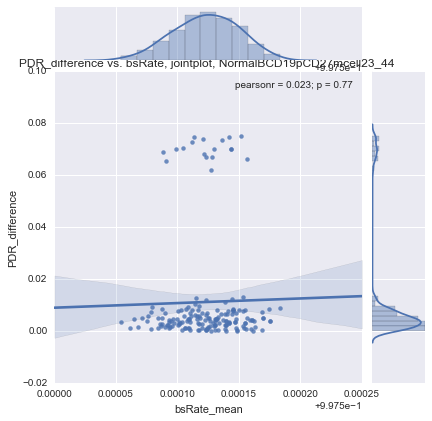

In [54]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs4a, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, NormalBCD19pCD27mcell23_44 ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


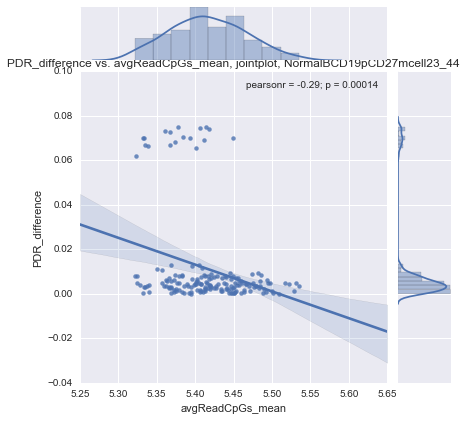

In [55]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs4a, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, NormalBCD19pCD27mcell23_44")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


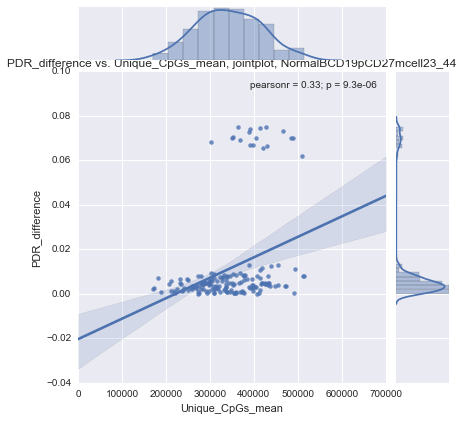

In [56]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs4a, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, NormalBCD19pCD27mcell23_44")

In [57]:
mcell = merged[merged["protocol"] == 'NormalBCD19pCD27mcell45_66']
mcell = mcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
mcell = mcell.reset_index(drop=True)
mcellA = mcell.set_index("filename")
from itertools import combinations
cc = list(combinations(mcell.filename,2))
out = pd.DataFrame([mcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(mcell.PDR, mcell.PDR)), mcell.filename, mcell.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs4b = pd.merge(out, pdr_differences, how='inner')
pairs4b = pairs4b.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs4b.PDR_difference # dependent variable
X = pairs4b.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'NormalBCD19pCD27mcell23_44', predict \delta PDR")
est.summary()

Regression results for 'NormalBCD19pCD27mcell23_44', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     12.43
Date:                Fri, 08 Jul 2016   Prob (F-statistic):           3.27e-07
Time:                        20:45:31   Log-Likelihood:                 589.42
No. Observations:                 136   AIC:                            -1171.
Df Residuals:                     132   BIC:                            -1159.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -36.0118      8.290     -4.344      0.000       -52.410   -19.613
avgReadCpGs_mean     0.0141      0.005      2.857      0.005         0.004     0.024
Unique_CpGs_mean  2.079e-09    5.3e-09      0.392      0.696     -8.41e-09  1.26e-08
bsRate_mean         36.0346      8.311      4.336      0.000        19.595    52.474
==============================================================================
Omnibus:                        1.801   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.406   Jarque-Bera (JB):                1.868
Skew:                           0.255   Prob(JB):                        0.393
Kurtosis:                       2.735   Cond. No.                     1.55e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


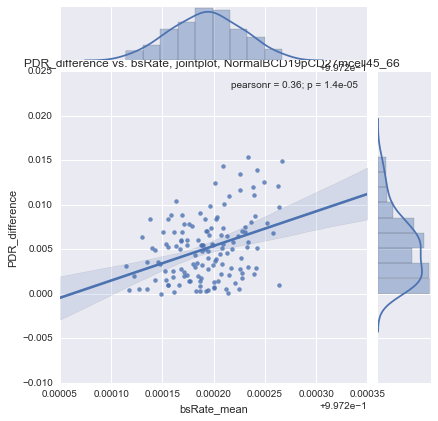

In [58]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs4b, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, NormalBCD19pCD27mcell45_66 ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


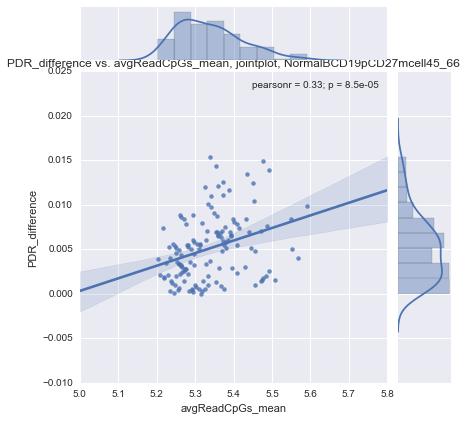

In [59]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs4b, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, NormalBCD19pCD27mcell45_66")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


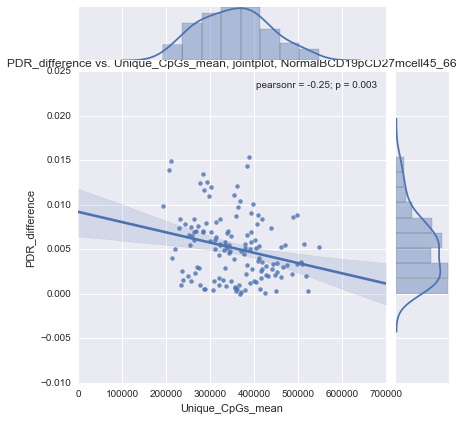

In [60]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs4b, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, NormalBCD19pCD27mcell45_66")

In [61]:
mcell = merged[merged["protocol"] == 'NormalBCD19pCD27mcell67_88']
mcell = mcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
mcell = mcell.reset_index(drop=True)
mcellA = mcell.set_index("filename")
from itertools import combinations
cc = list(combinations(mcell.filename,2))
out = pd.DataFrame([mcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(mcell.PDR, mcell.PDR)), mcell.filename, mcell.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs4c = pd.merge(out, pdr_differences, how='inner')
pairs4c = pairs4c.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs4c.PDR_difference # dependent variable
X = pairs4c.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'NormalBCD19pCD27mcell23_44', predict \delta PDR")
est.summary()

Regression results for 'NormalBCD19pCD27mcell23_44', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     8.107
Date:                Fri, 08 Jul 2016   Prob (F-statistic):           3.96e-05
Time:                        20:45:35   Log-Likelihood:                 571.04
No. Observations:                 210   AIC:                            -1134.
Df Residuals:                     206   BIC:                            -1121.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               49.2236     37.521      1.312      0.191       -24.751   123.198
avgReadCpGs_mean     0.0326      0.017      1.869      0.063        -0.002     0.067
Unique_CpGs_mean  6.514e-08   1.66e-08      3.921      0.000      3.24e-08  9.79e-08
bsRate_mean        -49.5437     37.621     -1.317      0.189      -123.716    24.629
==============================================================================
Omnibus:                       95.435   Durbin-Watson:                   0.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              268.785
Skew:                           2.057   Prob(JB):                     4.31e-59
Kurtosis:                       6.715   Cond. No.                     2.04e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


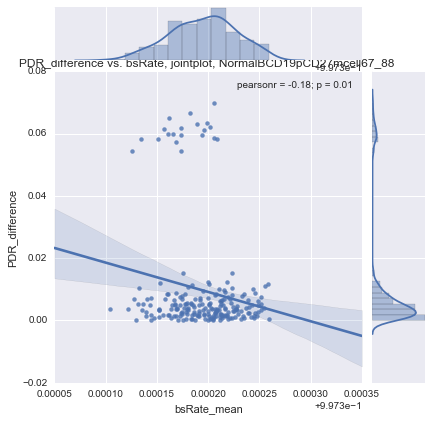

In [62]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs4c, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, NormalBCD19pCD27mcell67_88 ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


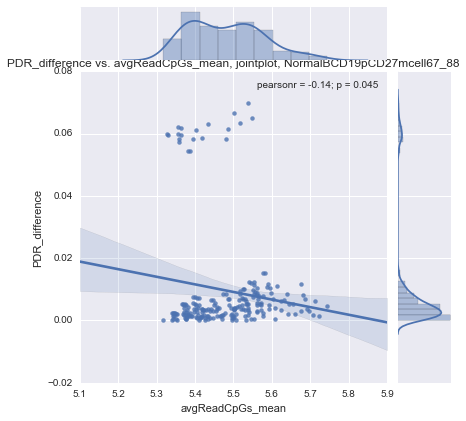

In [63]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs4c, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, NormalBCD19pCD27mcell67_88")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


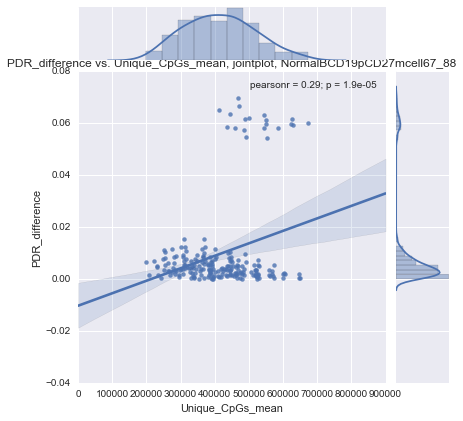

In [64]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs4c, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, NormalBCD19pCD27mcell67_88")

In [65]:
normb = merged[merged["protocol"] == 'normal_B_cell_A1_24']
normb = normb.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
normb = normb.reset_index(drop=True)
normbA = normb.set_index("filename")
from itertools import combinations
cc = list(combinations(normb.filename,2))
out = pd.DataFrame([normbA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(normb.PDR, normb.PDR)), normb.filename, normb.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs5 = pd.merge(out, pdr_differences, how='inner')
pairs5 = pairs5.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs5.PDR_difference # dependent variable
X = pairs5.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'normal_B_cell_A1_24', predict \delta PDR")
est.summary()

Regression results for 'normal_B_cell_A1_24', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.2140
Date:                Fri, 08 Jul 2016   Prob (F-statistic):              0.887
Time:                        20:45:38   Log-Likelihood:                 270.06
No. Observations:                 190   AIC:                            -532.1
Df Residuals:                     186   BIC:                            -519.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               -9.8385     15.725     -0.626      0.532       -40.860    21.183
avgReadCpGs_mean    -0.0431      0.084     -0.516      0.606        -0.208     0.122
Unique_CpGs_mean  2.565e-08   1.22e-07      0.210      0.834     -2.15e-07  2.66e-07
bsRate_mean         10.5823     16.446      0.643      0.521       -21.863    43.027
==============================================================================
Omnibus:                       61.905   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               12.944
Skew:                           0.300   Prob(JB):                      0.00155
Kurtosis:                       1.871   Cond. No.                     1.17e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


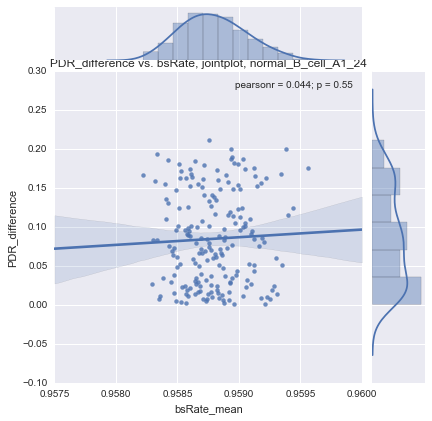

In [66]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs5, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, normal_B_cell_A1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


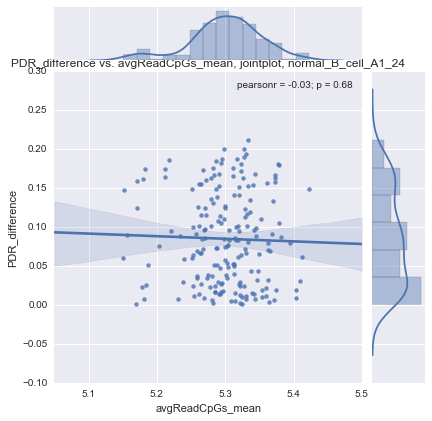

In [67]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs5, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, normal_B_cell_A1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


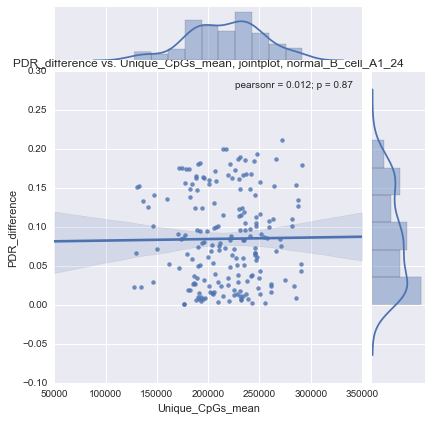

In [68]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs5, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, normal_B_cell_A1_24")

In [69]:
normb = merged[merged["protocol"] == 'normal_B_cell_B1_24']
normb = normb.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
normb = normb.reset_index(drop=True)
normbA = normb.set_index("filename")
from itertools import combinations
cc = list(combinations(normb.filename,2))
out = pd.DataFrame([normbA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(normb.PDR, normb.PDR)), normb.filename, normb.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs5a = pd.merge(out, pdr_differences, how='inner')
pairs5a = pairs5a.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs5a.PDR_difference # dependent variable
X = pairs5a.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'normal_B_cell_B1_24', predict \delta PDR")
est.summary()

Regression results for 'normal_B_cell_B1_24', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.5964
Date:                Fri, 08 Jul 2016   Prob (F-statistic):              0.618
Time:                        20:45:41   Log-Likelihood:                 251.88
No. Observations:                 190   AIC:                            -495.8
Df Residuals:                     186   BIC:                            -482.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -36.9410     41.227     -0.896      0.371      -118.274    44.392
avgReadCpGs_mean    -0.0844      0.076     -1.104      0.271        -0.235     0.066
Unique_CpGs_mean  1.262e-08   4.32e-08      0.292      0.770     -7.25e-08  9.78e-08
bsRate_mean         38.9960     43.170      0.903      0.368       -46.170   124.162
==============================================================================
Omnibus:                      364.530   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               15.730
Skew:                           0.107   Prob(JB):                     0.000384
Kurtosis:                       1.607   Cond. No.                     5.83e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.83e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


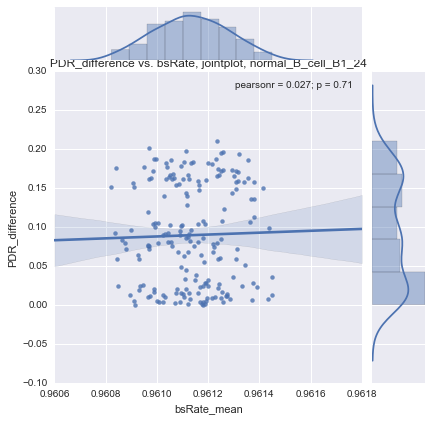

In [70]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs5a, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, normal_B_cell_B1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


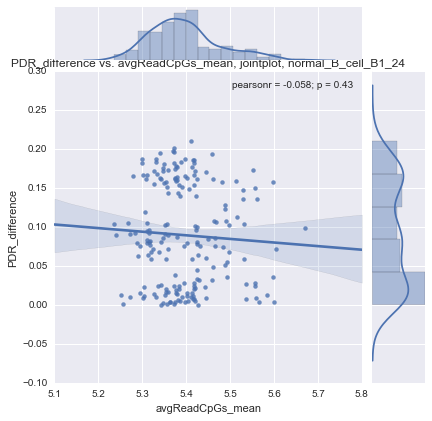

In [71]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs5a, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, normal_B_cell_B1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


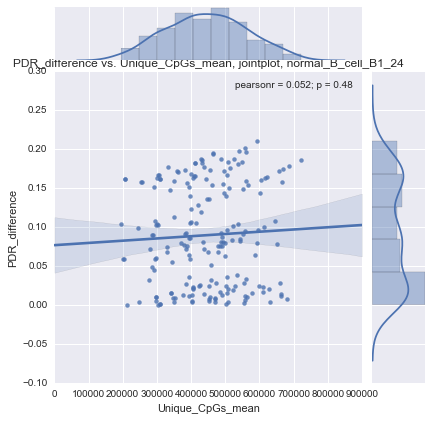

In [72]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs5a, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, normal_B_cell_B1_24")

In [73]:
normb = merged[merged["protocol"] == 'normal_B_cell_C1_24']
normb = normb.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
normb = normb.reset_index(drop=True)
normbA = normb.set_index("filename")
from itertools import combinations
cc = list(combinations(normb.filename,2))
out = pd.DataFrame([normbA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(normb.PDR, normb.PDR)), normb.filename, normb.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs5b = pd.merge(out, pdr_differences, how='inner')
pairs5b = pairs5b.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs5b.PDR_difference # dependent variable
X = pairs5b.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'normal_B_cell_C1_24', predict \delta PDR")
est.summary()

Regression results for 'normal_B_cell_C1_24', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.1971
Date:                Fri, 08 Jul 2016   Prob (F-statistic):              0.898
Time:                        20:45:45   Log-Likelihood:                 326.57
No. Observations:                 231   AIC:                            -645.1
Df Residuals:                     227   BIC:                            -631.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               23.5216     32.279      0.729      0.467       -40.082    87.126
avgReadCpGs_mean     0.0230      0.088      0.260      0.795        -0.151     0.197
Unique_CpGs_mean  2.197e-09   1.94e-08      0.113      0.910      -3.6e-08  4.04e-08
bsRate_mean        -24.4835     33.832     -0.724      0.470       -91.149    42.182
==============================================================================
Omnibus:                      102.924   Durbin-Watson:                   1.154
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               15.928
Skew:                           0.257   Prob(JB):                     0.000348
Kurtosis:                       1.821   Cond. No.                     9.25e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.25e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


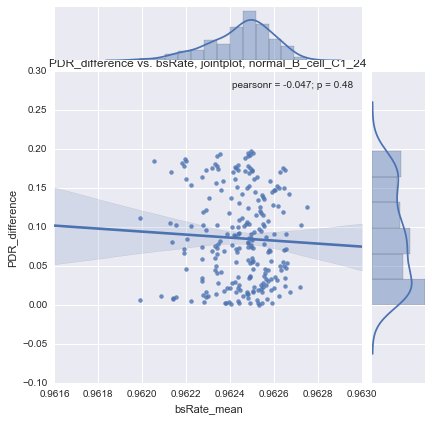

In [74]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs5b, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, normal_B_cell_C1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


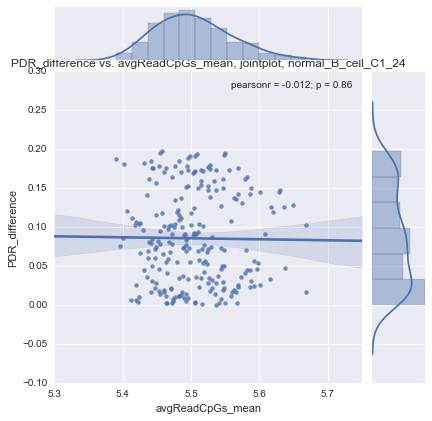

In [75]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs5b, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, normal_B_cell_C1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


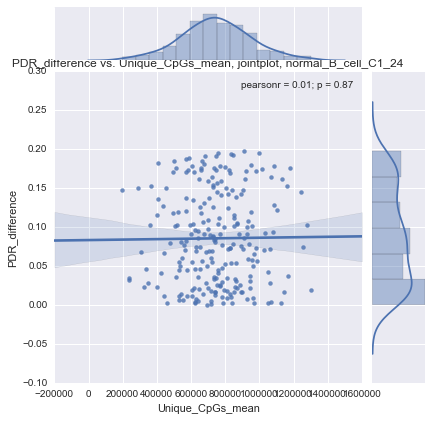

In [76]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs5b, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, normal_B_cell_C1_24")

In [77]:
normb = merged[merged["protocol"] == 'normal_B_cell_D1_24']
normb = normb.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
normb = normb.reset_index(drop=True)
normbA = normb.set_index("filename")
from itertools import combinations
cc = list(combinations(normb.filename,2))
out = pd.DataFrame([normbA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(normb.PDR, normb.PDR)), normb.filename, normb.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs5c = pd.merge(out, pdr_differences, how='inner')
pairs5c = pairs5c.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs5c.PDR_difference # dependent variable
X = pairs5c.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'normal_B_cell_D1_24', predict \delta PDR")
est.summary()

Regression results for 'normal_B_cell_D1_24', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                 -0.055
Method:                 Least Squares   F-statistic:                    0.3871
Date:                Fri, 08 Jul 2016   Prob (F-statistic):              0.763
Time:                        20:45:48   Log-Likelihood:                 55.699
No. Observations:                  36   AIC:                            -103.4
Df Residuals:                      32   BIC:                            -97.06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -22.7784     62.281     -0.366      0.717      -149.642   104.085
avgReadCpGs_mean    -0.1235      0.134     -0.921      0.364        -0.397     0.150
Unique_CpGs_mean  5.375e-08   6.25e-08      0.861      0.396     -7.35e-08  1.81e-07
bsRate_mean         24.4304     64.862      0.377      0.709      -107.689   156.550
==============================================================================
Omnibus:                       10.821   Durbin-Watson:                   1.656
Prob(Omnibus):                  0.004   Jarque-Bera (JB):                2.649
Skew:                          -0.113   Prob(JB):                        0.266
Kurtosis:                       1.691   Cond. No.                     7.43e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.43e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


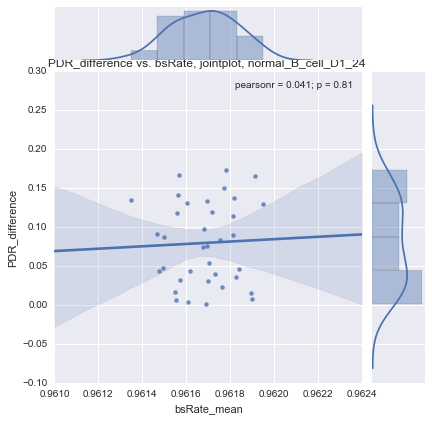

In [78]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs5c, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, normal_B_cell_D1_24 ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


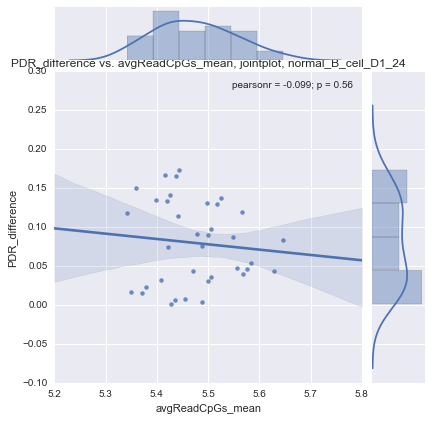

In [79]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs5c, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, normal_B_cell_D1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


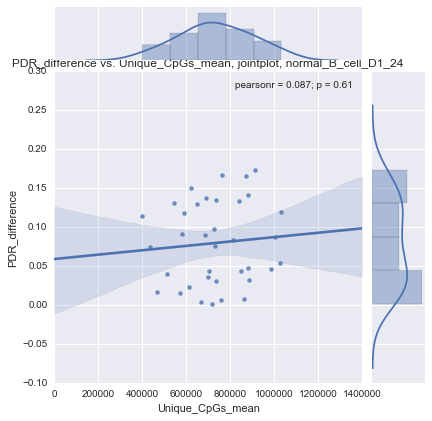

In [80]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs5c, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, normal_B_cell_D1_24")

In [81]:
normb = merged[merged["protocol"] == 'normal_B_cell_G1_22']
normb = normb.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
normb = normb.reset_index(drop=True)
normbA = normb.set_index("filename")
from itertools import combinations
cc = list(combinations(normb.filename,2))
out = pd.DataFrame([normbA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(normb.PDR, normb.PDR)), normb.filename, normb.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs5d = pd.merge(out, pdr_differences, how='inner')
pairs5d = pairs5d.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs5d.PDR_difference # dependent variable
X = pairs5d.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'normal_B_cell_G1_22', predict \delta PDR")
est.summary()

Regression results for 'normal_B_cell_G1_22', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     3.678
Date:                Fri, 08 Jul 2016   Prob (F-statistic):             0.0134
Time:                        20:45:51   Log-Likelihood:                 256.87
No. Observations:                 171   AIC:                            -505.7
Df Residuals:                     167   BIC:                            -493.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -36.4437     25.443     -1.432      0.154       -86.675    13.788
avgReadCpGs_mean     0.1277      0.093      1.367      0.174        -0.057     0.312
Unique_CpGs_mean -2.308e-09   3.92e-08     -0.059      0.953     -7.97e-08  7.51e-08
bsRate_mean         37.3120     26.790      1.393      0.166       -15.580    90.204
==============================================================================
Omnibus:                       47.336   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               12.058
Skew:                           0.350   Prob(JB):                      0.00241
Kurtosis:                       1.903   Cond. No.                     5.53e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.53e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


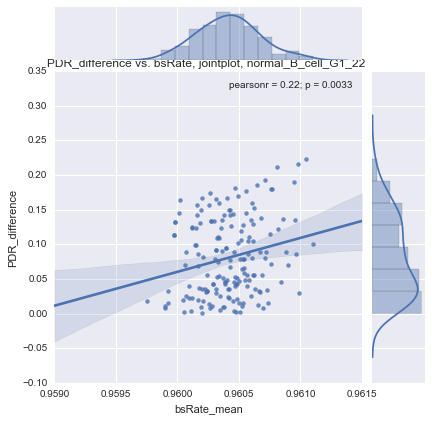

In [82]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs5d, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, normal_B_cell_G1_22 ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


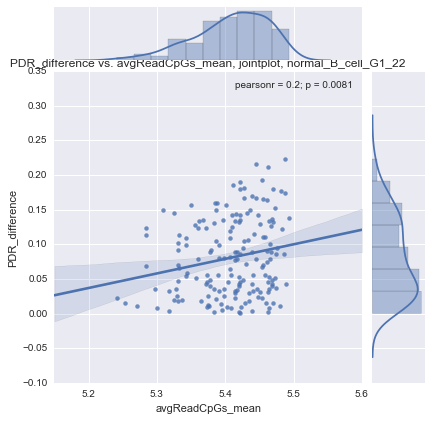

In [83]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs5d, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, normal_B_cell_G1_22")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


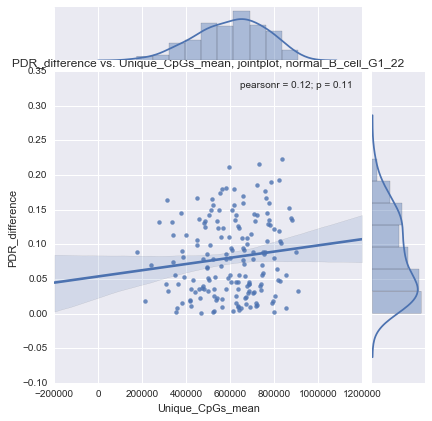

In [84]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs5d, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, normal_B_cell_G1_22")

In [85]:
normb = merged[merged["protocol"] == 'normal_B_cell_H1_22']
normb = normb.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
normb = normb.reset_index(drop=True)
normbA = normb.set_index("filename")
from itertools import combinations
cc = list(combinations(normb.filename,2))
out = pd.DataFrame([normbA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(normb.PDR, normb.PDR)), normb.filename, normb.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs5e = pd.merge(out, pdr_differences, how='inner')
pairs5e = pairs5e.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs5e.PDR_difference # dependent variable
X = pairs5e.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'normal_B_cell_H1_22', predict \delta PDR")
est.summary()

Regression results for 'normal_B_cell_H1_22', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.7583
Date:                Fri, 08 Jul 2016   Prob (F-statistic):              0.520
Time:                        20:45:54   Log-Likelihood:                 174.55
No. Observations:                 120   AIC:                            -341.1
Df Residuals:                     116   BIC:                            -330.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -14.6690     44.927     -0.327      0.745      -103.652    74.314
avgReadCpGs_mean    -0.1107      0.103     -1.071      0.286        -0.315     0.094
Unique_CpGs_mean  8.215e-08   6.11e-08      1.344      0.182     -3.89e-08  2.03e-07
bsRate_mean         15.9093     46.893      0.339      0.735       -76.968   108.787
==============================================================================
Omnibus:                       16.481   Durbin-Watson:                   1.232
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               11.044
Skew:                           0.609   Prob(JB):                      0.00400
Kurtosis:                       2.149   Cond. No.                     6.56e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.56e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


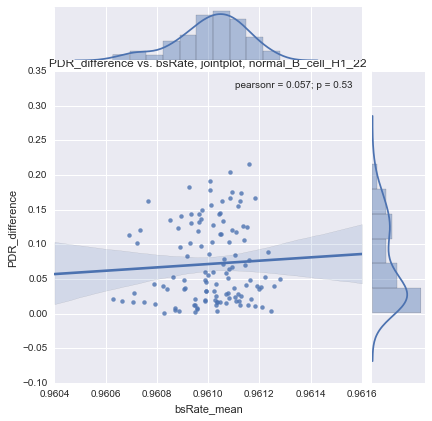

In [86]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs5e, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, normal_B_cell_H1_22")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


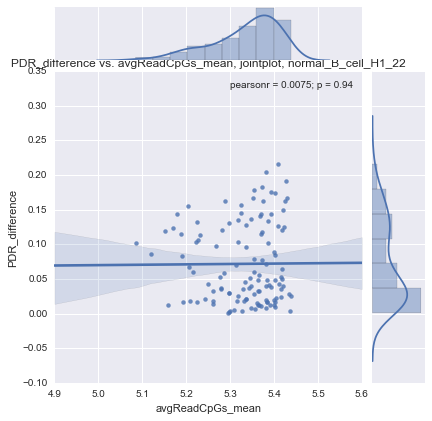

In [87]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs5e, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, normal_B_cell_H1_22")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


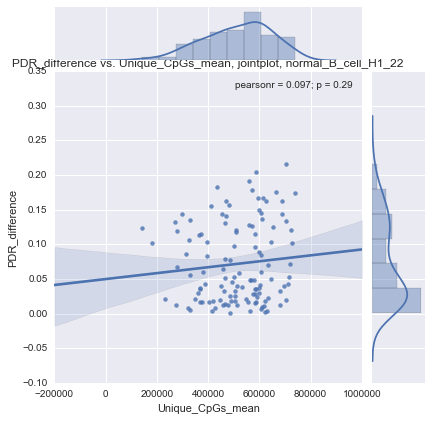

In [88]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs5e, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, normal_B_cell_H1_22")

In [89]:
pairs['type'] = str('CLL')
pairs1a['type'] = str('CLL')
pairs2['type'] = str('CLL')
pairs2a['type'] = str('CLL')
pairs2b['type'] = str('CLL')
pairs3['type'] = str('CLL')
pairs3a['type'] = str('normal')
pairs3b['type'] = str('normal')
pairs3c['type'] = str('normal')
pairs4['type'] = str('normal')
pairs4a['type'] = str('normal')
pairs4b['type'] = str('normal')
pairs4c['type'] = str('normal')
pairs5['type'] = str('normal')
pairs5a['type'] = str('normal')
pairs5b['type'] = str('normal')
pairs5c['type'] = str('normal')
pairs5d['type'] = str('normal')
pairs5e['type'] = str('normal')

frames22 = [pairs, pairs2, pairs3, pairs4]
total_pairs = pd.concat(frames22)
y = total_pairs.PDR_difference # dependent variable
X = total_pairs.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)

categorical_variables = ['type']
for variable in categorical_variables:
    # Fill missing data with the word "Missing"
    X[variable].fillna("Missing", inplace=True)
    # Create array of dummies
    dummies = pd.get_dummies(X[variable], prefix=variable)
    # Update X to include dummies and drop the main variable
    X = pd.concat([X, dummies], axis=1)
    X.drop([variable], axis=1, inplace=True)
    
X = X.drop(['type_normal'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results, all batches 'Normal B' vs 'CLL' , predict \delta PDR")
est.summary()

Regression results, all batches 'Normal B' vs 'CLL' , predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     158.3
Date:                Fri, 08 Jul 2016   Prob (F-statistic):           3.59e-97
Time:                        20:45:58   Log-Likelihood:                 1797.3
No. Observations:                 726   AIC:                            -3585.
Df Residuals:                     721   BIC:                            -3562.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               -1.0029      0.107     -9.409      0.000        -1.212    -0.794
avgReadCpGs_mean    -0.0221      0.009     -2.347      0.019        -0.041    -0.004
Unique_CpGs_mean -4.701e-08   3.33e-09    -14.122      0.000     -5.35e-08 -4.05e-08
bsRate_mean          1.1555      0.070     16.458      0.000         1.018     1.293
type_CLL             0.0395      0.003     15.654      0.000         0.035     0.045
==============================================================================
Omnibus:                      288.168   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1916.455
Skew:                           1.637   Prob(JB):                         0.00
Kurtosis:                      10.255   Cond. No.                     9.50e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.5e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


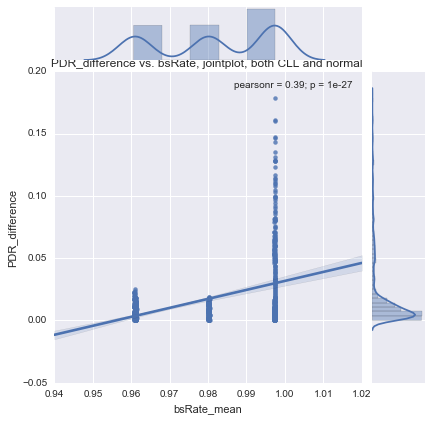

In [90]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=total_pairs, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, both CLL and normal ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


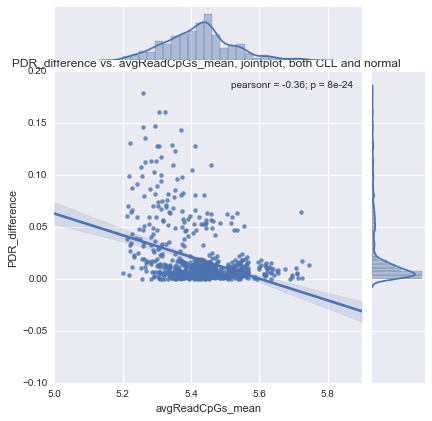

In [91]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=total_pairs, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, both CLL and normal ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


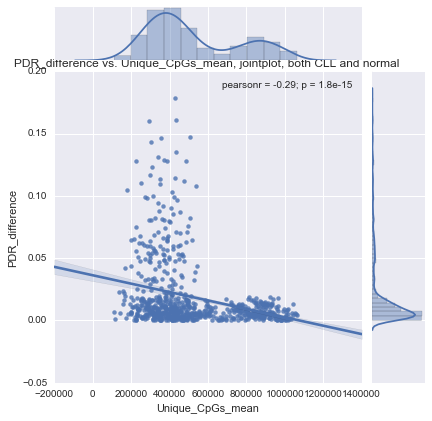

In [92]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=total_pairs, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, both CLL and normal ")

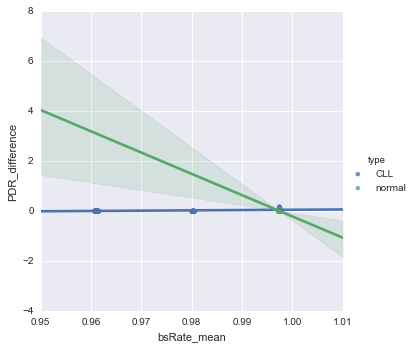

In [93]:
sns.lmplot(x="bsRate_mean", y="PDR_difference",  data=total_pairs, hue='type')

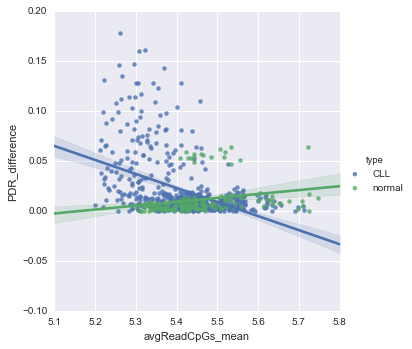

In [94]:
sns.lmplot(x="avgReadCpGs_mean", y="PDR_difference",  data=total_pairs, hue='type')

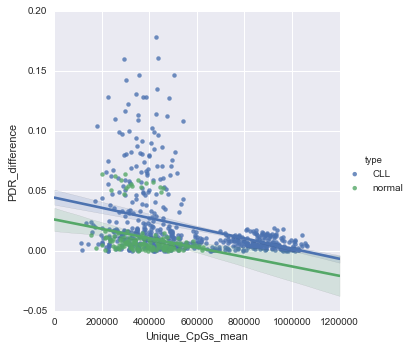

In [95]:
sns.lmplot(x="Unique_CpGs_mean", y="PDR_difference",  data=total_pairs, hue='type')

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:8: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


Random Forest model score is 0.901069892878


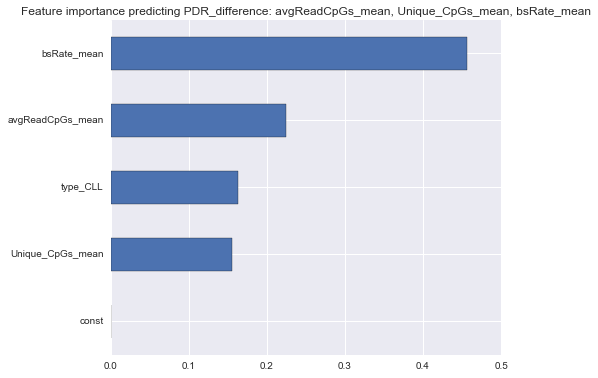

In [96]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

model = RandomForestRegressor(n_estimators=1000, oob_score=True, random_state=36)
model.fit(X, y)
# Simple version that shows all of the variables
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort()
feature_importances.plot(kind="barh", figsize=(7,6))
plt.title("Feature importance predicting PDR_difference: avgReadCpGs_mean, Unique_CpGs_mean, bsRate_mean")
print(str("Random Forest model score is ") + str(model.score(X,y)))